In [3]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

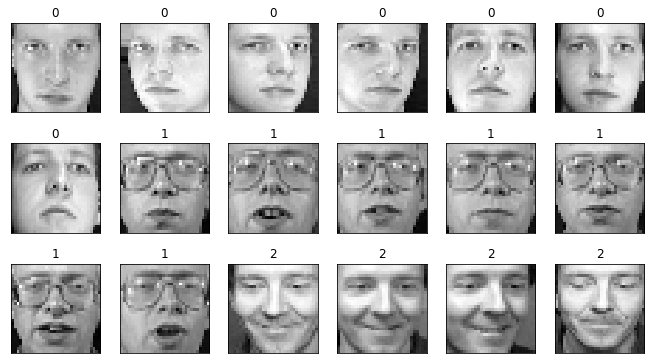

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train.ravel())

test_score = knn_classifier.score(X_test, y_test)
print('Test KNN score: {}'.format(test_score))

Test KNN score: 0.783333333333


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [6]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
from sklearn import preprocessing
X_train_processed = preprocessing.scale(X_train)
X_test_processed = preprocessing.scale(X_test)

D:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [7]:
from sklearn.decomposition import PCA

n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.
# DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train_processed)

We plot a bunch of principal components.

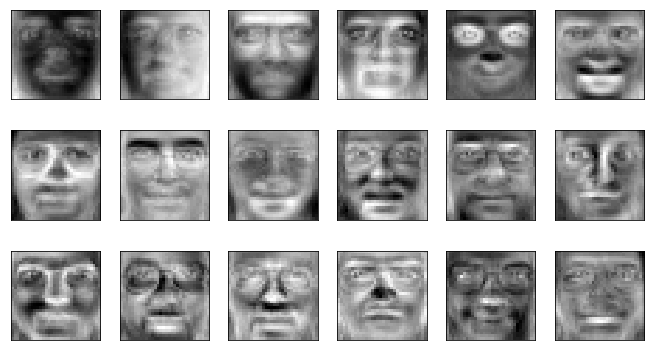

In [8]:
# Visualize principal components.

plot_gallery(pca.components_, [""] * pca.components_.shape[0], image_h, image_w)

This time we don't have any restriction on number of non-zero coefficients in the vector decomposition, so the codes are not sparse anymore:

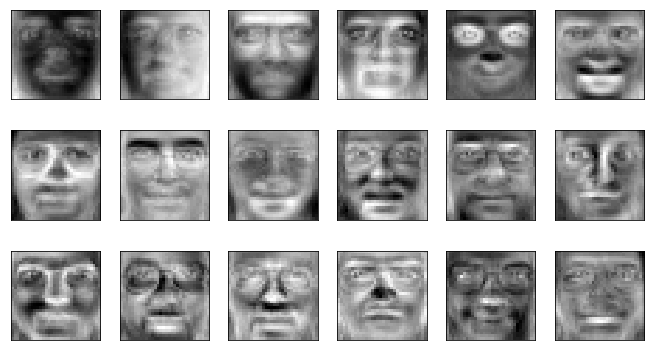

In [9]:
# Transform training data and plot decomposition coefficients.

reshaped_pca = pca.components_.reshape((n_components, image_h, image_w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

plot_gallery(reshaped_pca, [""] * reshaped_pca.shape[0], image_h, image_w)

Train an SVM and apply it to the encoded test data.

In [10]:
# Populate 'test_score' with test accuracy of an SVM classifier.
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e-2, 1, 1e2, 0.1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1e-1, 1, 1e1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train, y_train.ravel())

test_score = clf.best_estimator_.score(X_test, y_test)

print('Test SVM_RBF score: {}'.format(test_score))

Test SVM_RBF score: 0.891666666667


In [11]:
# Let's try another svm - with linear kernel 
from sklearn.svm import SVC, LinearSVC
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e-2, 1, 1e2, 0.1]}
clf1 = GridSearchCV(SVC(kernel='linear'), param_grid)
clf1 = clf1.fit(X_train, y_train.ravel())

test_score = clf1.best_estimator_.score(X_test, y_test)

print('Test Linear SVM score: {}'.format(test_score))

Test Linear SVM score: 0.95


In [19]:
# Let's try another svm - with linear kernel 
from sklearn.svm import SVC, LinearSVC

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e-2, 1, 1e2, 0.1, 0.2]}
clf2 = GridSearchCV(LinearSVC(), param_grid)
clf2 = clf1.fit(X_train_pca, y_train.ravel())

test_score = clf2.best_estimator_.score(X_test_pca, y_test)

print('Test Linear SVM with pca score: {}'.format(test_score))

Test Linear SVM with pca score: 0.941666666667


How many components are sufficient to reach the same accuracy level?

1
0.0583333333333
2
0.116666666667
4
0.266666666667
8
0.708333333333
16
0.9
32
0.908333333333
64
0.991666666667
Max accuracy: 0.991666666667


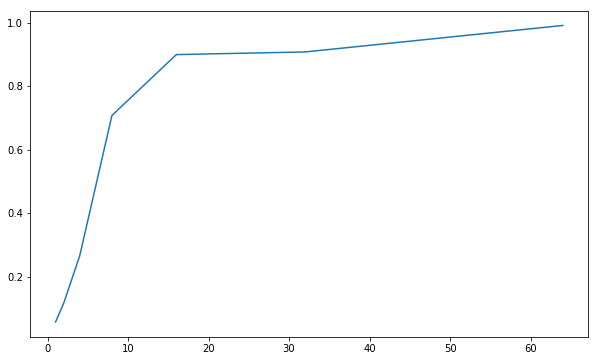

In [24]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

for n_c in n_components:
    iterarations_accur = []
    
    # on the most reasonable count of components let's do more iterations to select the best random )
    iterations = 100 if n_c == 64 else 2
    for i in xrange(1, iterations):
        pca=PCA(n_components=n_c, svd_solver='randomized', whiten=True, tol=0.2).fit(X_train_processed)
        X_train_pca = pca.transform(X_train_processed)
        X_test_pca = pca.transform(X_test_processed) 

        clf = LinearSVC(C=0.1)
        clf = clf.fit(X_train_pca, y_train.ravel())
        iteration_score = clf.score(X_test_pca, y_test)
        iterarations_accur.append(iteration_score)
        
    print n_c
    score = max(iterarations_accur)
    print score
    
    accuracy.append(score)


# Try different numbers of components and populate 'accuracy' list.
    
plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))